# Novelty

In [1]:
from ipynb.fs.full.koselleck import *

[Koselleck] (20:28:14) Alles bereit 


In [2]:
def make_foote(quart=FOOTE_W):
    tophalf = [-1] * quart + [1] * quart
    bottomhalf = [1] * quart + [-1] * quart
    foote = list()
    for i in range(quart):
        foote.append(tophalf)
    for i in range(quart):
        foote.append(bottomhalf)
    foote = np.array(foote)
    return foote

def foote_novelty(distdf, foote_size=5):
    foote=make_foote(foote_size)
    distmat = distdf.values if type(distdf)==pd.DataFrame else distdf
    
    axis1, axis2 = distmat.shape
    assert axis1 == axis2
    distsize = axis1
    axis1, axis2 = foote.shape
    assert axis1 == axis2
    halfwidth = axis1 / 2
    novelties = []
    for i in range(distsize):
        start = int(i - halfwidth)
        end = int(i + halfwidth)
        if start < 0 or end > (distsize - 1):
            novelties.append(0)
        else:
            novelties.append(np.sum(foote * distmat[start: end, start: end]))
    return novelties

def getyears():
    years=list(d.columns)
    return years


def diagonal_permute(d):
    newmat = np.zeros(d.shape)
    
    # We create one randomly-permuted list of integers called "translate"
    # that is going to be used for the whole matrix.
    
    xlen,ylen=d.shape
    translate = [i for i in range(xlen)]
    random.shuffle(translate)
    
    # Because distances matrices are symmetrical, we're going to be doing
    # two diagonals at once each time. We only need one set of values
    # (because symmetrical) but we need two sets of indices in the original
    # matrix so we know where to put the values back when we're done permuting
    # them.
    
    for i in range(0, xlen):
        indices1 = []
        indices2 = []
        values = []
        for x in range(xlen):
            y1 = x + i
            y2 = x - i
            if y1 >= 0 and y1 < ylen:
                values.append(d[x, y1])
                indices1.append((x, y1))
            if y2 >= 0 and y2 < ylen:
                indices2.append((x, y2))
        
        # Okay, for each diagonal, we permute the values.
        # We'll store the permuted values in newvalues.
        # We also check to see how many values we have,
        # so we can randomly select values if needed.
        
        newvalues = []
        lenvals = len(values)
        vallist = [i for i in range(lenvals)]
        
        for indexes, value in zip(indices1, values):
            x, y = indexes
            
            xposition = translate[x]
            yposition = translate[y]
            
            # We're going to key the randomization to the x, y
            # values for each point, insofar as that's possible.
            # Doing this will ensure that specific horizontal and
            # vertical lines preserve the dependence relations in
            # the original matrix.
            
            # But the way we're doing this is to use the permuted
            # x (or y) values to select an index in our list of
            # values in the present diagonal, and that's only possible
            # if the list is long enough to permit it. So we check:
            
            if xposition < 0 and yposition < 0:
                position = random.choice(vallist)
            elif xposition >= lenvals and yposition >= lenvals:
                position = random.choice(vallist)
            elif xposition < 0:
                position = yposition
            elif yposition < 0:
                position = xposition
            elif xposition >= lenvals:
                position = yposition
            elif yposition >= lenvals:
                position = xposition
            else:
                position = random.choice([xposition, yposition])
                # If either x or y could be used as an index, we
                # select randomly.
            
            # Whatever index was chosen, we use it to select a value
            # from our diagonal. 
            
            newvalues.append(values[position])
            
        values = newvalues
        
        # Now we lay down (both versions of) the diagonal in the
        # new matrix.
        
        for idxtuple1, idxtuple2, value in zip(indices1, indices2, values):
            x, y = idxtuple1
            newmat[x, y] = value
            x, y = idxtuple2
            newmat[x, y] = value
    
    return newmat

def zeroless(sequence):
    newseq = []
    for element in sequence:
        if element > 0.01:
            newseq.append(element)
    return newseq

def permute_test(distmatrix, foote_size=FOOTE_W, num_runs=100):
    actual_novelties = foote_novelty(distmatrix, foote_size)    
    permuted_peaks = []
    permuted_troughs = []
    xlen,ylen=distmatrix.shape
    for i in range(num_runs):
        randdist = diagonal_permute(distmatrix)
        nov = foote_novelty(randdist, foote_size)
        nov = zeroless(nov)
        permuted_peaks.append(np.max(nov))
        permuted_troughs.append(np.min(nov))
    permuted_peaks.sort(reverse = True)
    permuted_troughs.sort(reverse = True)
    significance_peak = np.ones(len(actual_novelties))
    significance_trough = np.ones(len(actual_novelties))
    for idx, novelty in enumerate(actual_novelties):
        ptop=[i for i,x in enumerate(permuted_peaks) if x and x < novelty]
        ptop=ptop[0]/num_runs if ptop else 1
        pbot=[i for i,x in enumerate(permuted_troughs) if x and x > novelty]
        pbot=pbot[-1]/num_runs if pbot else 1
        significance_peak[idx]=ptop
        significance_trough[idx]=pbot
        
        
    
    return actual_novelties, significance_peak, significance_trough

def colored_segments(novelties, significance, yrwidth=1,min_year=1700):
    x = []
    y = []
    t = []
    idx = 0
    for nov, sig in zip(novelties, significance):
        if nov > 1:
            x.append((idx*yrwidth) + min_year)
            y.append(nov)
            t.append(sig)
        idx += 1
        
    x = np.array(x)
    y = np.array(y)
    t = np.array(t)
    
    points = np.array([x,y]).transpose().reshape(-1,1,2)
    segs = np.concatenate([points[:-1],points[1:]],axis=1)
    lc = LineCollection(segs, cmap=plt.get_cmap('jet'))
    lc.set_array(t)
    
    return lc, x, y
    
    
def test_novelty(distdf, foote_sizes=None, num_runs=100):
    if not foote_sizes: foote_sizes=range(FOOTE_W-3, FOOTE_W+2)
    dq=distdf.fillna(0).values
    o=[]
    for fs in foote_sizes:
        try:
            novelties, significance_peak, significance_trough = permute_test(dq, foote_size=fs, num_runs=num_runs)
        except ValueError as e:
#             print('!!',e,'!!')
#             print(distdf)
            continue
        for year,nov,sigp,sigt in zip(distdf.columns, novelties, significance_peak, significance_trough):
            odx={
                'period':year,
                'foote_novelty':nov,
                'foote_size':fs,
                'p_peak':sigp,
                'p_trough':sigt,
            }
            o.append(odx)
    return pd.DataFrame(o)


In [3]:
def nov(word_or_words,
        num_proc=1, progress=True,
        ybin=YBIN_DISTMAT,ymin=YMIN_DISTMAT,ymax=YMAX_DISTMAT,k=K,
        min_foote_size=MINFOOTENOW,max_foote_size=MAXFOOTENOW,
        force=False,cache_only=False,
        **distmat_opts):
    #print(f'nov({word_or_words})')
    objs_todo=objs=[
        dict(
            word=w,
            qstr=f'{w}/{ymin}-{ymax}_by{ybin}/k={k}',
            progress=False,
            ybin=ybin,ymax=ymax,ymin=ymin,k=k,
            **distmat_opts
        ) for w in to_words(word_or_words)
    ]
    objs_done={}    
    if not force:
        with get_db('nov',mode='r') as db:
            objs_done=dict(
                (
                    x['qstr'],
                    db.get(x['qstr']) if not cache_only else pd.DataFrame(),
                )
                for x in objs
                if x['qstr'] in db
            )
            objs_todo=[x for x in objs if x['qstr'] not in objs_done]
    if len(objs_todo):
        objs_done_now={}
        iterr=pmap_iter(
            nov_word_,
            objs_todo,
            num_proc=num_proc,
            progress=progress if len(objs_todo)>1 else False
        )
        with get_db('nov',mode='c') as db:
            for i,odf in enumerate(iterr):
                if odf is not None and len(odf):
                    qstr=odf.iloc[0].qstr
                    odf=odf.drop('qstr',1)
                    #objs_done_now[qstr]=odf
                    db[qstr]=odf
                    objs_done[qstr]=odf if not cache_only else pd.DataFrame()
                if i and not i%10: db.commit()
            db.commit()
    odf=pd.concat(list(objs_done.values()))# if not cache_only else None
    odf=odf.query(f'{min_foote_size}<=foote_size<={max_foote_size}')
    return odf
    
    
def nov_word_(obj): return nov_word(**obj)        
def nov_word(word,qstr=None,force=False,**distmat_opts):
    try:
        dfdist=distmat(word,force=force,**distmat_opts)
        odf=test_novelty(
            dfdist
        ).assign(
            word=word
        ).query('foote_novelty!=0').set_index(['word','period'])
        if qstr: odf=odf.assign(qstr=qstr)
        return odf
    except Exception as e:
#         print('!!',e)
        return pd.DataFrame()


In [4]:
res=nov('value')#,ymin=1720,ymax=1960,force=True)
res

foote_novelty  foote_size  p_peak  p_trough
word  period                                                
value 1740-1745       0.501830           4    1.00      1.00
      1745-1750       0.987509           4    0.96      1.00
      1750-1755       1.254894           4    0.70      1.00
      1755-1760       1.282561           4    0.63      1.00
      1760-1765       0.947988           4    0.98      1.00
...                        ...         ...     ...       ...
      1905-1910       1.960688           6    1.00      1.00
      1910-1915       2.106818           6    1.00      1.00
      1915-1920       1.710880           6    1.00      1.00
      1920-1925       1.507225           6    1.00      1.00
      1925-1930       1.251391           6    1.00      0.03

[114 rows x 4 columns]

### Run all words

In [5]:
def gen_novelty_data(words=None,num_proc=6,**attrs):
    if not words: words=get_valid_words()
    nov(words, num_proc=num_proc, cache_only=True, **attrs)

In [6]:
# gen_novelty_data(
# #     ymin=YMIN_DISTMAT_BIG, ymax=YMAX_DISTMAT_BIG,  ybin=YBIN_DISTMAT_BIG,
#     ymin=1720, ymax=1960, ybin=5,
#     force=True, num_proc=4
# )
# goodwork

## Novelty scores

In [7]:
def get_novelty(words,ybin=YBIN_DISTMAT,ymin=YMIN_DISTMAT,ymax=YMAX_DISTMAT,k=K,
                min_foote_size=MINFOOTENOW,max_foote_size=MAXFOOTENOW,force=False,**nov_attrs):
#     global DFALLNOV
    wordkey=str(tuple([w for w in sorted(to_words(words))] + [ybin, ymin, ymax, min_foote_size, max_foote_size]))
    
    if not force:
        with get_db('nov','r') as db:
            if wordkey in db: return db[wordkey]
    odf=nov(
        words,
        ybin=ybin,ymin=ymin,ymax=ymax,k=k,
        force=False,progress=True,
        **nov_attrs
    )
    odf=odf.query(f'{min_foote_size}<=foote_size<={max_foote_size}')
    odf=pd.concat(
        grp.assign(foote_novelty_z=(grp.foote_novelty - grp.foote_novelty.mean()) / grp.foote_novelty.std())
        for i,grp in odf.groupby('foote_size')
    )
    odf=odf.reset_index()
    odf['period_str']=odf['period']
    odf['period']=odf['period'].apply(lambda x: int(x[:4]))
    odf['is_signif']=odf['p_peak']<=0.05
    #DFALLNOV[wordkey]=odf
    with get_db('nov','w') as db: db[wordkey]=odf
    return odf

def get_all_novelty_scores(words=None,force=False,
                           min_foote_size=MINFOOTENOW,max_foote_size=MAXFOOTENOW,
                           ymin=YMIN_DISTMAT,ymax=YMAX_DISTMAT,ybin=YBIN_DISTMAT,
                           **attrs):
    key=f'_all_nov_scores_{min_foote_size}-{max_foote_size}.{ymin}-{ymax}_{ybin}__{sorted(attrs.items())}'
    odf=None
    if not force:
        with get_db('nov') as db:
            if key in db: odf=db[key]
    if odf is None:
        print('Computing...')
        dfallnov=get_novelty(get_valid_words() if not words else words,**attrs).sort_values('foote_novelty')
        dfallnov['period_int']=dfallnov['period'].apply(int)
        dfallnov=dfallnov.query(f'{min_foote_size}<=foote_size<={max_foote_size}')
        dfallnov=dfallnov.merge(get_word2pos_df(),on='word')
        print('Caching')
        with get_db('nov','w') as db: db[key]=dfallnov
        print('Done')
        odf=dfallnov
    return odf.query(f'{min_foote_size}<=foote_size<={max_foote_size}')

In [8]:
dfallnov=get_all_novelty_scores(force=True)#force=True)#min_foote_size=3,max_foote_size=6,ybin=5,ymin=1680,ymax=1960).sort_values('period')
dfallnov.sort_values('period')

[Koselleck] (20:28:14) Computing... (+0.2s)
[Koselleck] (20:28:16) Caching (+1.6s)
[Koselleck] (20:28:16) Done (+0.7s)


,word,period,foote_novelty,foote_size,p_peak,p_trough,foote_novelty_z,period_str,is_signif,period_int,pos
780045,hoar,1740,1.053615,4,1.00,1.00,0.503956,1740-1745,False,1740,nn1
208644,hoped,1740,0.300915,4,1.00,1.00,-0.926775,1740-1745,False,1740,v
387638,gracious,1740,0.406453,4,1.00,1.00,-0.726168,1740-1745,False,1740,j
173570,crowded,1740,0.581818,4,1.00,1.00,-0.392834,1740-1745,False,1740,j
1287028,flop,1740,0.648209,4,1.00,0.04,-0.266639,1740-1745,False,1740,nn1
...,...,...,...,...,...,...,...,...,...,...,...
1344996,cooks,1935,0.637014,4,1.00,1.00,-0.287918,1935-1940,False,1935,nn2
935313,coins,1935,0.516436,4,1.00,1.00,-0.517113,1935-1940,False,1935,nn2
685764,relative,1935,1.590763,4,0.74,1.00,1.524965,1935-1940,False,1935,j
935179,parcel,1935,0.984390,4,1.00,1.00,0.372373,1935-1940,False,1935,nn1


## Significant words

In [9]:
def get_signif_novelty_scores(
        p_peak=0.05,
        min_peaks=2,
        force=False,
        consecutive_peaks=True,
        ybin=YBIN_DISTMAT,
        ymin=YMIN_DISTMAT,
        ymax=YMAX_DISTMAT,
        min_foote_size=MINFOOTENOW,#FOOTE_W-1,
        max_foote_size=MAXFOOTENOW,#FOOTE_W+1,
        min_word_len=4,
        only_peak_scores=False,
        **atr):
    key=str(
        (p_peak,min_peaks,consecutive_peaks,ybin,ymin,ymax,
         min_foote_size,max_foote_size,min_word_len,only_peak_scores)
    )
    if not force:
        with get_db('nov','r') as db:
            if key in db: return db[key]
    
    odf=get_all_novelty_scores(
        min_foote_size=min_foote_size,
        max_foote_size=max_foote_size,
        ymin=ymin,
        ybin=ybin,
        ymax=ymax,
        force=force,
        **atr).query(f'p_peak<={p_peak}')
    if min_word_len: odf=odf[odf.word.apply(lambda x: len(x)>=min_word_len)]
    odf=pd.concat(
        grp.assign(word_num_peaks=len(grp))
        for i,grp in tqdm(odf.groupby(['word','foote_size']),desc='Calculating numbber of peaks')
    )
    if min_peaks: odf=odf[odf.word_num_peaks>=min_peaks]
    if consecutive_peaks and min_peaks>1:
        l=[]
        for (wx,fs),g in tqdm(odf.groupby(['word','foote_size']),desc='Filtering consecutive peaks'):
            g=g.sort_values('period_int')
            for i in range(1,len(g)):
                prev=g.iloc[i-1]
                this=g.iloc[i]
                if int(prev.period)+ybin != int(this.period):
                    break
            else:
                l+=[g]
        odf=pd.concat(l) if len(l) else pd.DataFrame()
    if len(odf):
        odf=odf.sort_values(
            'foote_novelty_z',
            ascending=False
        )#.reset_index()
        if only_peak_scores:
            odf=odf.drop_duplicates('word')
        
    with get_db('nov','w') as db: db[key]=odf    
    return odf

In [10]:
get_signif_novelty_scores(only_peak_scores=True,force=0)

,word,period,foote_novelty,foote_size,p_peak,p_trough,foote_novelty_z,period_str,is_signif,period_int,pos,word_num_peaks
200706,sound,1800,9.766796,4,0.00,1.0,17.065945,1800-1805,True,1800,nn1,3
1230627,fins,1815,14.552565,5,0.00,1.0,16.725748,1815-1820,True,1815,nn2,4
1408025,cloth,1830,14.414710,5,0.00,1.0,16.553091,1830-1835,True,1830,nn1,3
832683,crystal,1850,13.755975,5,0.00,1.0,15.728057,1850-1855,True,1850,nn1,4
1170906,foil,1815,13.622346,5,0.00,1.0,15.560694,1815-1820,True,1815,nn1,4
...,...,...,...,...,...,...,...,...,...,...,...,...
59914,reason,1760,0.940901,5,0.00,1.0,-0.322207,1760-1765,True,1760,nn1,2
41450,order,1915,1.343409,6,0.00,1.0,-0.350391,1915-1920,True,1915,nn1,2
67149,kind,1750,0.824004,5,0.03,1.0,-0.468614,1750-1755,True,1750,nn1,2
128948,happen,1915,1.093481,6,0.01,1.0,-0.564967,1915-1920,True,1915,v,2


In [11]:
get_signif_novelty_scores(force=0)

,word,period,foote_novelty,foote_size,p_peak,p_trough,foote_novelty_z,period_str,is_signif,period_int,pos,word_num_peaks
200706,sound,1800,9.766796,4,0.00,1.0,17.065945,1800-1805,True,1800,nn1,3
1230627,fins,1815,14.552565,5,0.00,1.0,16.725748,1815-1820,True,1815,nn2,4
1230622,fins,1815,9.549142,4,0.00,1.0,16.652230,1815-1820,True,1815,nn2,3
1408025,cloth,1830,14.414710,5,0.00,1.0,16.553091,1830-1835,True,1830,nn1,3
1230629,fins,1815,20.522430,6,0.00,1.0,16.115802,1815-1820,True,1815,nn2,5
...,...,...,...,...,...,...,...,...,...,...,...,...
41444,order,1910,0.738900,5,0.03,1.0,-0.575203,1910-1915,True,1910,nn1,2
128947,happen,1910,1.062043,6,0.02,1.0,-0.591958,1910-1915,True,1910,v,2
24503,long,1810,0.868905,6,0.00,1.0,-0.757777,1810-1815,True,1810,j,3
24502,long,1800,0.818953,6,0.02,1.0,-0.800664,1800-1805,True,1800,j,3


In [12]:
def get_signif_novelty_scores_summary(force=False,**opts):
    key=str(sorted(opts.items()))
    if not force:
        with get_db('nov') as db:
            if key in db: return db[key]
    
    df=get_signif_novelty_scores(force=force,**opts)
    df=pd.concat(
        grp.assign(
            changepoint=grp.period_int.min(),
            changepoint_avg=grp.period_int.median(),
            changepoint_peak=grp.groupby('period_int').mean().sort_values('foote_novelty',ascending=False).index[0]
        )
        for i,grp in tqdm(df.groupby('word'))
    )
    df=df.groupby(['word','pos']).agg(['min','mean','max'])
    df.columns = [f'{x}_{y}' if y!='mean' else x
                  for x,y in df.columns.to_flat_index()]
    
    df['nov_rank']=df.foote_novelty.rank(ascending=False)
    df=df.sort_values('nov_rank')
    df=df.reset_index().set_index('word')
    with get_db('nov','w') as db: db[key]=df
    return df

In [13]:
df=get_signif_novelty_scores_summary(force=0).sort_values('foote_novelty_max',ascending=False)
# df.pos

In [14]:
def get_signif_novelty_words(**opts):
    return set(get_signif_novelty_scores_summary().index)

In [15]:
signw=get_signif_novelty_words()
len(signw)

4875

In [16]:
# odfsum=get_signif_novelty_scores_summary(min_foote_size=4,max_foote_size=6)
# odfsum

In [17]:
# dfsign=get_signif_novelty_scores(force=False,min_foote_size=2)
# dfsign#[dfsign.word=='culture']

## Plotting

In [18]:
# get_all_novelty_scores(force=True)

### Signif words

In [19]:

def make_figdf(dfsign=None,dtype='signif_word',
               rolling_n=1,rolling_min_periods=1,min_all_periods=None,only_max_periods=True,
               ymin=YMIN_DISTMAT,ymax=YMAX_DISTMAT):
    if dfsign is None: dfsign=get_signif_novelty_scores()
    s=get_all_novelty_scores().groupby('word').size().sort_values()
    if only_max_periods: s=s[s==s.max()]
    elif min_all_periods: s=s[s>=min_all_periods]
    ok_words=set(s.index)
#     print(len(ok_words))

    l=[]
#     print(len(dfsign))
    idf=dfsign[dfsign.word.isin(ok_words)]
#     print(len(idf))
    if 'pos' not in set(idf.columns): idf=idf.merge(get_word2pos_df(),on='word')
    #for (fs,pos),dfsign_fs in idf.groupby(['foote_size','pos']):
    for pos,dfsign_pos in idf.groupby('pos'):
        odf=dfsign_pos.set_index('period').sort_index()
        odf['num_peaks']=odf.groupby('period').size()
        odf['num_peaks_rel']=odf.num_peaks / odf.num_peaks.max()
        odf=odf.rolling(rolling_n,min_periods=rolling_min_periods).mean()
        odf['dtype']=dtype
        odf['pos']=pos
        l+=[odf.reset_index()]
    odf=pd.concat(l) if len(l) else pd.DataFrame()
    return odf#.query(f'{ymin}<=period<{ymax}')

def is_safe_fs(w):
    return not ('s' in w or 'f' in w)

In [20]:
make_figdf(rolling_n=5,rolling_min_periods=5)

,period,foote_novelty,foote_size,p_peak,p_trough,foote_novelty_z,is_signif,period_int,word_num_peaks,num_peaks,num_peaks_rel,dtype,pos
0,1740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,signif_word,j
1,1740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,signif_word,j
2,1740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,signif_word,j
3,1740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,signif_word,j
4,1740,1.900767,4.0,0.018,1.0,2.114219,1.0,1740.0,2.4,14.0,0.061674,signif_word,j
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3262,1935,2.215513,4.0,0.014,1.0,2.712488,1.0,1935.0,2.4,32.0,0.112281,signif_word,v
3263,1935,2.240444,4.0,0.012,1.0,2.759878,1.0,1935.0,2.2,32.0,0.112281,signif_word,v
3264,1935,2.346012,4.0,0.016,1.0,2.960540,1.0,1935.0,2.2,32.0,0.112281,signif_word,v
3265,1935,2.144121,4.0,0.026,1.0,2.576787,1.0,1935.0,2.4,32.0,0.112281,signif_word,v


In [21]:
# get_signif_novelty_scores()

In [22]:
# def get_figdf_nov_signif():
    

In [23]:
def plot_nov_signif(figdf=None,y='num_peaks',save=False,showdata=False,vnum='v3',
                    key='_figdf_nov_signif_',force=False,
                    rolling_n=2,rolling_min_periods=2,returndata_all=False,force_data=False,
                    by_foote_size=False
                   ):
    p9.options.dpi=300
    nudge_x=2
    ymin=0
    labsize=6
    
    if figdf is None and not returndata_all:
        if not force:
            with get_db('nov') as db:
                if key in db: figdf=db[key]
    
    if figdf is None or returndata_all:
        cats=[
            ('all','I. All words'),
            ('lax','II. Signif. (p<.05)'),
            ('strict','III. Signif. (p<.05) in 2 consecutive periods)'),
#             ('lax_nofs','Signif. (p<.05; no suspicious OCR words)'),
            ('strict_nofs','IV. Signif. (p<.05) in 2 consecutive periods, excl. words with "f" or "s")'),
#             ('strict_nofs_first','Signif. (words) (p<.001 in 3 consecutive periods; no suspicious OCR words)')
        ]
        dfnov_all=get_signif_novelty_scores(
            min_foote_size=MINFOOTENOW,max_foote_size=MAXFOOTENOW,
            p_peak=1,consecutive_peaks=False,min_periods=1,
            ymin=YMIN_DISTMAT,ymax=YMAX_DISTMAT,ybin=YBIN_DISTMAT,force=force_data,
            only_peak_scores=True
        )
#         display(dfnov_all)
        dfnov_lax=get_signif_novelty_scores(
            min_foote_size=MINFOOTENOW,max_foote_size=MAXFOOTENOW,
            p_peak=.05,consecutive_peaks=False,min_periods=1,
            ymin=YMIN_DISTMAT,ymax=YMAX_DISTMAT,ybin=YBIN_DISTMAT,force=force_data,
            only_peak_scores=True
        )
#         display(dfnov_lax)
        dfnov_strict=get_signif_novelty_scores(
            min_foote_size=MINFOOTENOW,max_foote_size=MAXFOOTENOW,
            p_peak=.05,consecutive_peaks=True,min_periods=2,
            ymin=YMIN_DISTMAT,ymax=YMAX_DISTMAT,ybin=YBIN_DISTMAT,force=force_data,
            only_peak_scores=True
        )
        dfnov_strict_nofs=dfnov_strict[dfnov_strict.word.apply(is_safe_fs)]
#         dfnov_lax_nofs=dfnov_lax[dfnov_lax.word.apply(is_safe_fs)]

#         dfnov_srict_nofs_first=dfnov_strict_nofs.sort_values('foote_novelty',ascending=False).drop_duplicates('word')
        dfl=[
            dfnov_all,
            dfnov_lax,
            dfnov_strict,
#             dfnov_lax_nofs,
            dfnov_strict_nofs,
#             dfnov_srict_nofs_first
        ]
        if returndata_all:
            return pd.concat(
                dfx.assign(dtype2=cat[1],dtype3=cat[1])
                for cat,dfx in zip(cats,dfl)
            )
        l=[]
        for cat,dfx in zip(cats,dfl):
#             print(cat)
#             display(dfx)
            odfx=make_figdf(
                dfx,rolling_n=rolling_n,rolling_min_periods=rolling_min_periods
            ).assign(dtype2=cat[1], dtype3=cat[0])
#             display(odfx)
            l+=[odfx]
        
            
        figdf=pd.concat(l)
        figdf['dtype2']=pd.Categorical(figdf.dtype2, categories=[yy for xx,yy in cats])
        figdf['dtype3']=pd.Categorical(figdf.dtype3, categories=[xx for xx,yy in cats])
        # figdf.sort_values('period')
#         figdf['foote_size']=figdf.foote_size.apply(lambda x: f'{int(x)*5*2} year window')
#         print(figdf.period.describe())
#         display(figdf)
        figdf=figdf.query('1750<=period_int<1930')
#         print(figdf.period.describe())
        with get_db('nov','w') as db: db[key]=figdf
    
    figdf['pos']=figdf.pos.apply(lambda x: POSD.get(x,x))
    if showdata: display(figdf)
    fig=start_fig(
        figdf,
        x='period',
        y=y,
    #     linetype='foote_size',
        shape='pos',
        color='pos',
        theme='classic',
        size='foote_novelty',
        figure_size=(8,8)
    ) + p9.geom_point() + p9.geom_line(size=.5)
    
#     fig+=p9.geom_text(
#         p9.aes(label='period',x='period',y=y),
#         inherit_aes=False,
#         data=figdf.sort_values(y,ascending=False).groupby(['pos','dtype2']).head(1).reset_index()
#     )
    
#     fig+=p9.geom_smooth(method='loess',alpha=.2,span=.4,size=.5)
    fig+=p9.geom_vline(xintercept=1770,linetype='dotted',alpha=0.5) 
    fig+=p9.geom_vline(xintercept=1800,linetype='dotted',alpha=0.5) 
    fig+=p9.geom_vline(xintercept=1830,linetype='dotted',alpha=0.5) 
    fig+=p9.geom_vline(xintercept=1900,linetype='dotted',alpha=0.5) 
    fig+=p9.geom_vline(xintercept=1800,linetype='dotted',alpha=0.5) 
    fig+=p9.geom_label(label='Sattelzeit begins (1770)',x=1770+nudge_x,y=ymin,angle=90,size=labsize,color='black',va='bottom',boxcolor=(0,0,0,0),ha='left')
    fig+=p9.geom_label(label='Sattelzeit ends (1830)',x=1830+nudge_x,y=ymin,angle=90,size=labsize,color='black',va='bottom',boxcolor=(0,0,0,0),ha='left')
    fig+=p9.geom_label(label='Turn of C19',x=1800+nudge_x,y=ymin,angle=90,size=labsize,color='black',va='bottom',boxcolor=(0,0,0,0),ha='left')
    fig+=p9.geom_label(label='Turn of C20',x=1900+nudge_x,y=ymin,angle=90,size=labsize,color='black',va='bottom',boxcolor=(0,0,0,0),ha='left')

    fig+=p9.facet_wrap('dtype2',ncol=1,scales='free_y')#,nrow=1)#,ncol=1
#     fig+=p9.facet_grid('dtype2~pos',scales='free_y')#,nrow=1)#,ncol=1
#     fig+=p9.facet_grid('dtype2~foote_size',scales='free_y')#,nrow=1)#,ncol=1
    fig+=p9.scale_color_gray(start=.8,end=.2)
    fig+=p9.scale_size_continuous([.1,3])
    fig+=p9.labs(
        title='Number of words which "pivot", or reach their peak novelty score, in a given period',
        y='Number of words pivoting in this period',
        x='Pivot period for word (peak novelty)'
    )
    fig+=p9.scale_x_continuous(breaks=list(range(1740,1940,20)))
    if save:
        ofn=f'fig.nov_summary.{y}.{vnum}.png'
        fig.save(os.path.join(PATH_FIGS,ofn))
        shutil.copyfile(os.path.join(PATH_FIGS,ofn), os.path.join(PATH_FIGS2,ofn))
    
    return fig

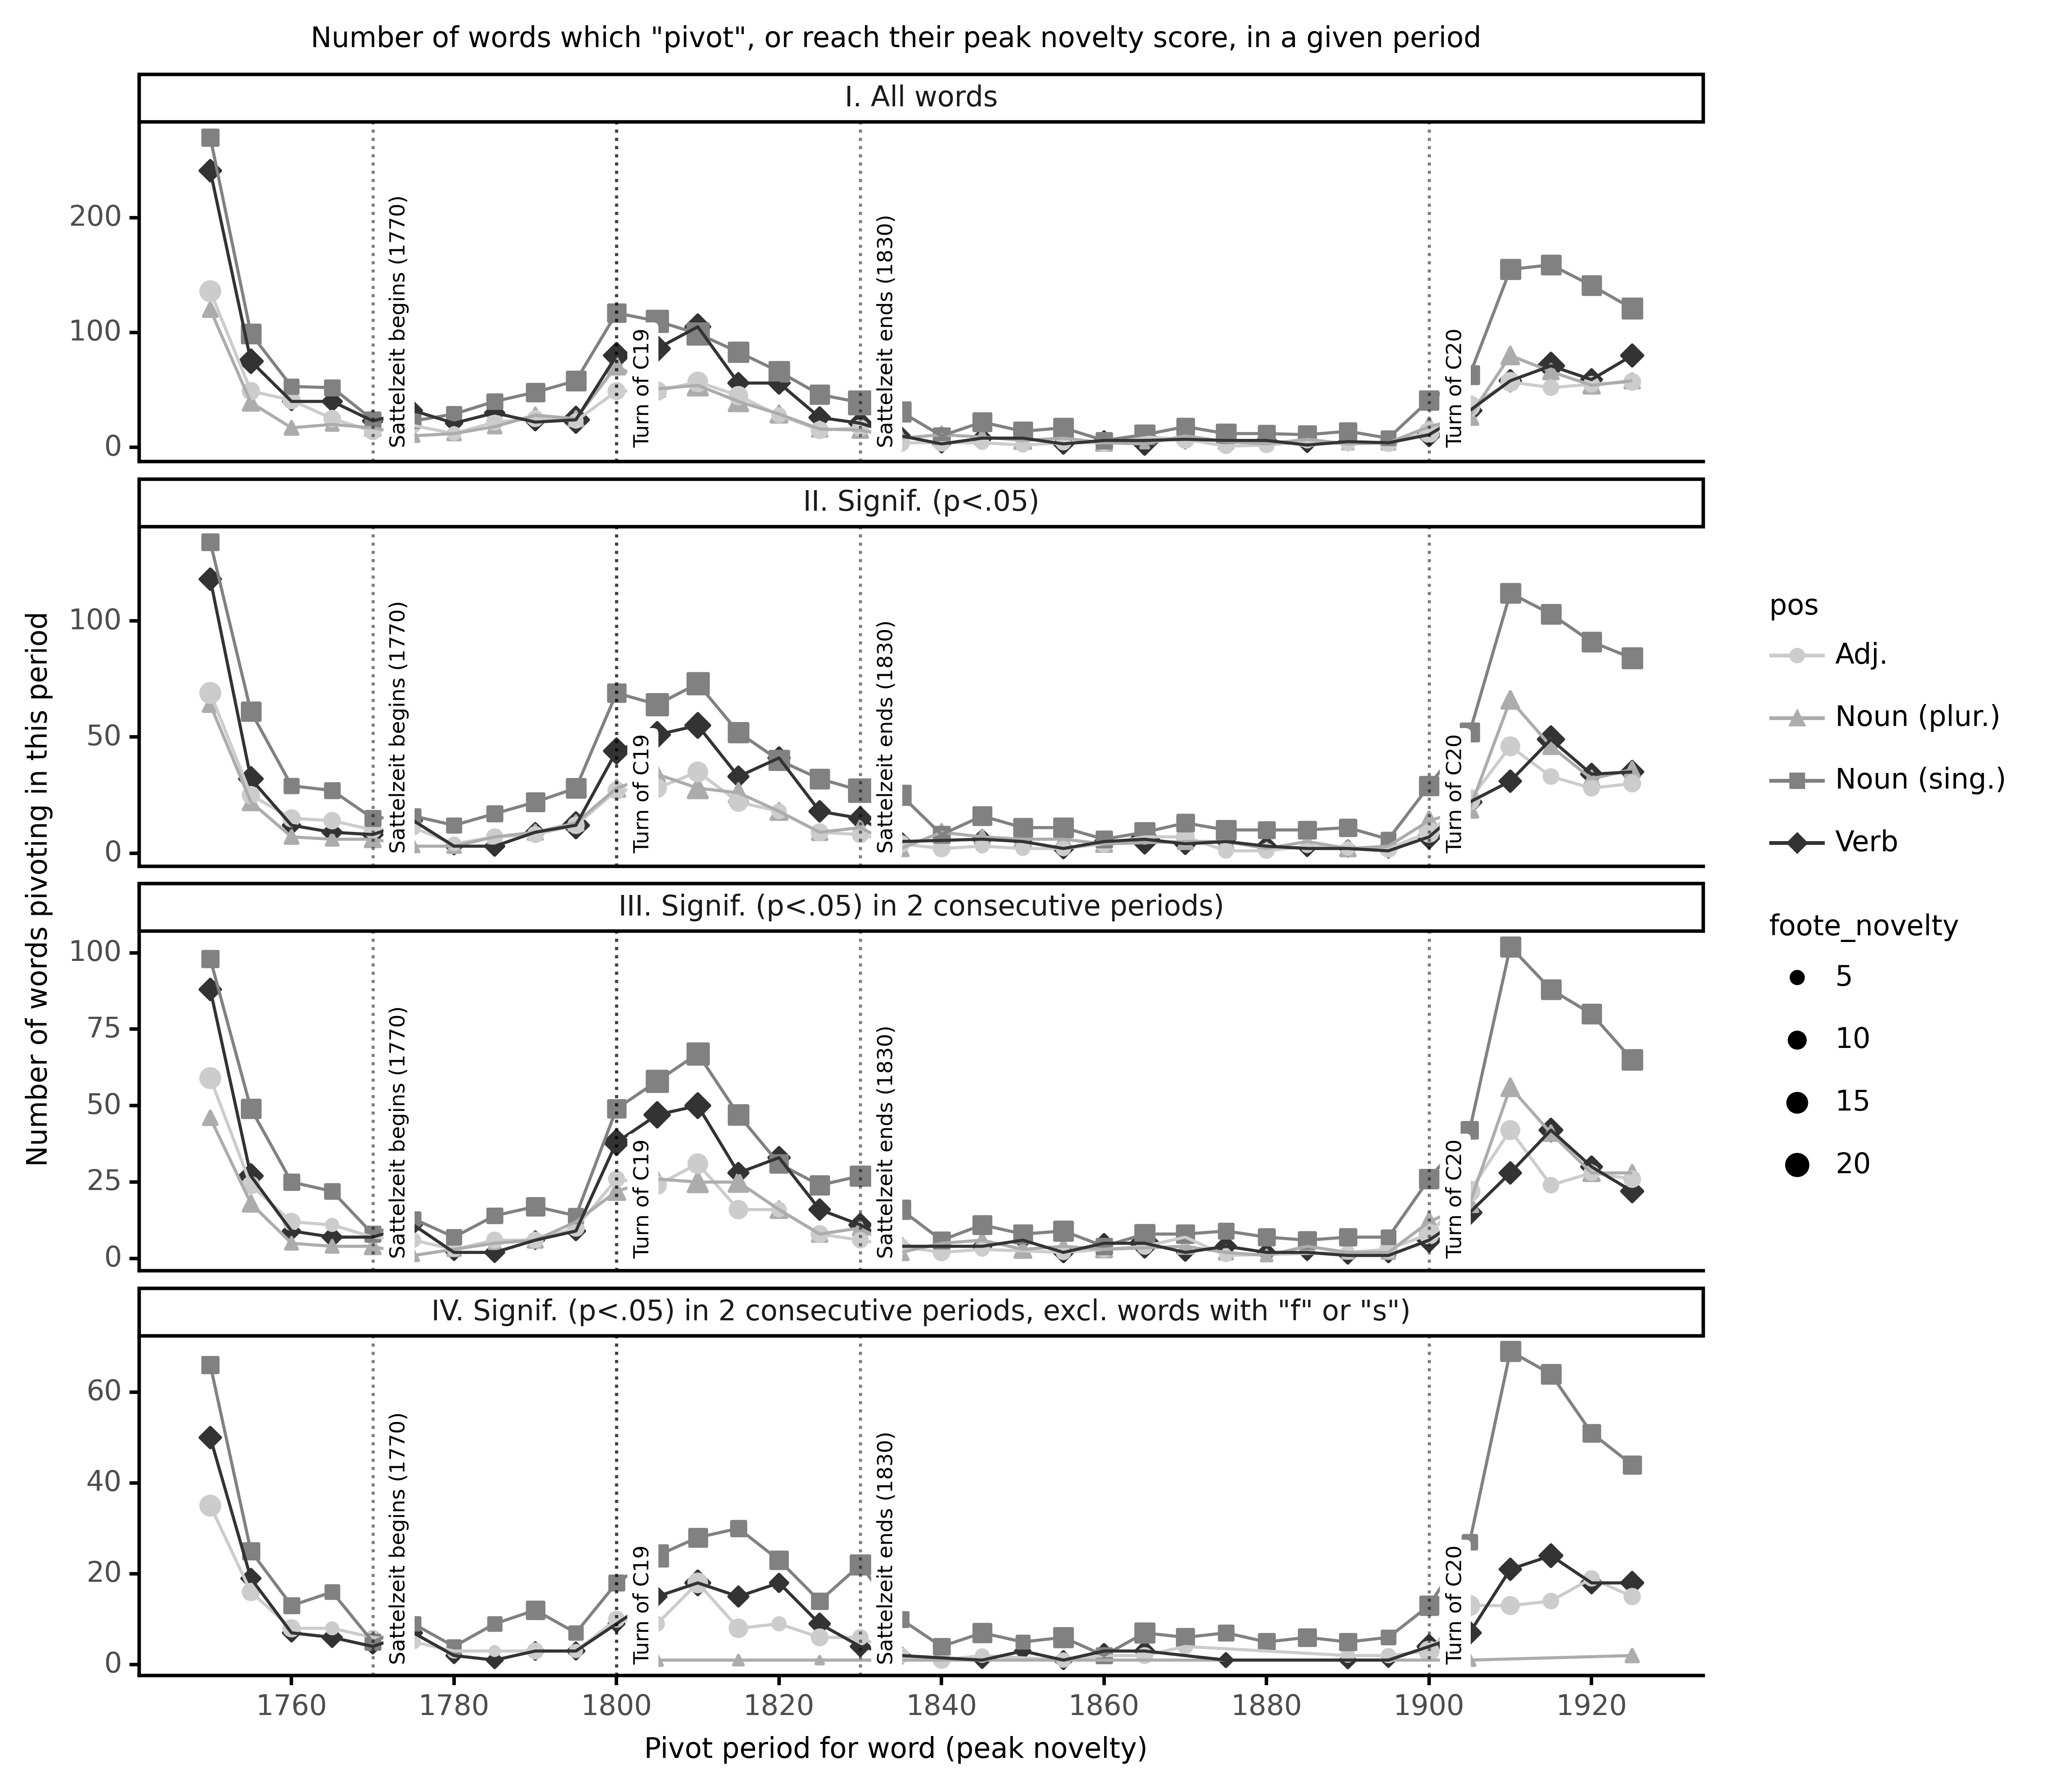

<ggplot: (8730200785942)>

In [24]:
plot_nov_signif(
    y='num_peaks',
    vnum='v12',
    force=True,
#     force_data=True,
    rolling_n=1,
    rolling_min_periods=1,
#     showdata=True,
    by_foote_size=False,
#     returndata_all=True
)

In [ ]:
plot_nov_signif(
#     figdf,#.query('1920>=period>=1740'),
    y='num_peaks',
    save=True,
    vnum='v11',
#     force=True,
    rolling_n=1,
    rolling_min_periods=1,
#     force_data=True,
#     showdata=True,
    by_foote_size=False,
#     returndata_all=True
)

In [ ]:
def plot_nov_word(
        word_or_words,
        y='foote_novelty',
        save=False,
        nudge_x=2,
        nudge_y=.1,
        ymin=-50,
        labsize=6,
        rolling=2,
        min_foote_size=MINFOOTENOW,
        max_foote_size=MAXFOOTENOW,
        vnum=gettodaysdate(),
        **nov_opts):
    figdf=nov(word_or_words,**nov_opts).reset_index()
    figdf['period']=[int(x[:4]) for x in figdf['period']]
    figdf['is_signif']=[int(x<=0.05) for x in figdf.p_peak]
    figdf=figdf.groupby(['word','period']).mean().reset_index()
    figdf['is_signif']*=100
    figdf['is_signif_str']=[f'{x:.0f}%' for x in (figdf.is_signif//10*10)]
    figdf=pd.concat(
        g.assign(foote_novelty=g.foote_novelty.rolling(rolling,min_periods=1).mean())
        for i,g in figdf.groupby('word')
    )
    
    fig=start_fig(
        figdf,
        x='period',
        y=y,
#         linetype='foote_size',
        size='is_signif_str',
        shape='word',
        color='word',
        figure_size=(8,5),
        theme='classic',
        group='word'
    )
    fig+=p9.ylim(0, math.ceil(figdf[y].max()))
    fig+=p9.geom_point()#size=1.5)
    fig+=p9.geom_line(size=.7)
    fig+=p9.scale_color_gray()
    fig+=p9.scale_size_discrete(
        range=[.5,3],
    )
    
    #label peaks
    labeldf=figdf.sort_values(y,ascending=False).drop_duplicates('word')
    labeldf[y]+=nudge_y
    fig+=p9.geom_text(p9.aes(label='word'), data=labeldf, size=7, color='black')
    
    
#     fig+=p9.geom_smooth(method='loess',alpha=.2,span=.4, size=.5)
    fig+=p9.geom_vline(xintercept=1770,linetype='dotted',alpha=0.5) 
    fig+=p9.geom_vline(xintercept=1800,linetype='dotted',alpha=0.5) 
    fig+=p9.geom_vline(xintercept=1830,linetype='dotted',alpha=0.5) 
    fig+=p9.geom_label(label='Sattelzeit begins (1770)',x=1770+nudge_x,y=0,angle=90,size=labsize,color='black',va='bottom',boxcolor=(0,0,0,0))
    fig+=p9.geom_label(label='Sattelzeit ends (1830)',x=1830+nudge_x,y=0,angle=90,size=labsize,color='black',va='bottom',boxcolor=(0,0,0,0)) 

#     fig+=p9.facet_wrap('dtype2',ncol=1,scales='free_y')
    wstr='-'.join(sorted(figdf.word.unique()))
    if save:
        ofn=f'fig.nov_word.{wstr}.{y}.{vnum}.png'
        fig.save(os.path.join(PATH_FIGS,ofn))
        if PATH_FIGS2: fig.save(os.path.join(PATH_FIGS2,ofn))
#         print('Saved:',ofn)
    return fig

## Examine

In [ ]:
#plot_nov_word('value,virtue,station',min_foote_size=6)
res=interact(plot_nov_word, word_or_words=WORD)

In [ ]:
# def plot_nov_signif(figdf=None,y='num_peaks',save=False,showdata=False,vnum='v3',
#                     key='_figdf_nov_signif_',force=False,
#                     rolling_n=2,rolling_min_periods=2,returndata_all=False,force_data=False,
#                     by_foote_size=False
#                    ):
#     p9.options.dpi=300
#     nudge_x=2
#     ymin=0
#     labsize=6
    
#     if figdf is None:
#         if not force:
#             with get_db('nov') as db:
#                 if key in db: figdf=db[key]
    
#     if figdf is None:
#         cats=[
#             ('all','I. All words'),
#             ('lax','II. Signif. (p<.05)'),
#             ('strict','III. Signif. (p<.05 in 2 consecutive periods)'),
# #             ('lax_nofs','Signif. (p<.05; no suspicious OCR words)'),
#             ('strict_nofs','IV. Signif. (p<.05 in 2 consecutive periods; excl. words with "f" or "s")'),
# #             ('strict_nofs_first','Signif. (words) (p<.001 in 3 consecutive periods; no suspicious OCR words)')
#         ]
#         dfnov_all=get_signif_novelty_scores(
#             min_foote_size=MINFOOTENOW,max_foote_size=MAXFOOTENOW,
#             p_peak=1,consecutive_peaks=False,min_periods=1,
#             ymin=YMIN_DISTMAT,ymax=YMAX_DISTMAT,ybin=YBIN_DISTMAT,force=force_data,
#             only_peak_scores=True
#         )
# #         display(dfnov_all)
#         dfnov_lax=get_signif_novelty_scores(
#             min_foote_size=MINFOOTENOW,max_foote_size=MAXFOOTENOW,
#             p_peak=.05,consecutive_peaks=False,min_periods=1,
#             ymin=YMIN_DISTMAT,ymax=YMAX_DISTMAT,ybin=YBIN_DISTMAT,force=force_data,
#             only_peak_scores=True
#         )
# #         display(dfnov_lax)
#         dfnov_strict=get_signif_novelty_scores(
#             min_foote_size=MINFOOTENOW,max_foote_size=MAXFOOTENOW,
#             p_peak=.05,consecutive_peaks=True,min_periods=2,
#             ymin=YMIN_DISTMAT,ymax=YMAX_DISTMAT,ybin=YBIN_DISTMAT,force=force_data,
#             only_peak_scores=True
#         )
#         dfnov_strict_nofs=dfnov_strict[dfnov_strict.word.apply(is_safe_fs)]
# #         dfnov_lax_nofs=dfnov_lax[dfnov_lax.word.apply(is_safe_fs)]

# #         dfnov_srict_nofs_first=dfnov_strict_nofs.sort_values('foote_novelty',ascending=False).drop_duplicates('word')
#         dfl=[
#             dfnov_all,
#             dfnov_lax,
#             dfnov_strict,
# #             dfnov_lax_nofs,
#             dfnov_strict_nofs,
# #             dfnov_srict_nofs_first
#         ]
#         if returndata_all:
#             return pd.concat(
#                 dfx.assign(dtype2=cat[1],dtype3=cat[1])
#                 for cat,dfx in zip(cats,dfl)
#             )
        
#         figdf=pd.concat(
#             make_figdf(
#                 dfx,rolling_n=rolling_n,rolling_min_periods=rolling_min_periods
#             ).assign(dtype2=ystr, dtype3=xstr)
#             for ((xstr,ystr),dfx) in zip(cats,dfl)
#         )
#         figdf['dtype2']=pd.Categorical(figdf.dtype2, categories=[yy for xx,yy in cats])
#         figdf['dtype3']=pd.Categorical(figdf.dtype3, categories=[xx for xx,yy in cats])
#         # figdf.sort_values('period')
#         figdf['foote_size']=figdf.foote_size.apply(lambda x: f'{int(x)*5*2} year window')
# #         print(figdf.period.describe())
#         figdf=figdf.query('1750<=period<1930')
# #         print(figdf.period.describe())
#         with get_db('nov','w') as db: db[key]=figdf
    
#     if not by_foote_size:
#         figdf=figdf.groupby(['period','pos','dtype2']).agg(
#             {'num_peaks':'sum','foote_novelty':'mean'}
#         ).reset_index()
#         figdf['group']=[f'{x}_{y}' for x,y in zip(figdf.pos,figdf.dtype2)]
#     else:
#         figdf['group']=figdf['foote_size']
    
#     if showdata: display(figdf)
#     fig=start_fig(
#         figdf,
#         x='period',
#         y=y,
#     #     linetype='foote_size',
#         shape='pos' if not by_foote_size else 'foote_size',
#         color='pos' if not by_foote_size else 'foote_size',
#         group='group',#pos' if not by_foote_size else 'foote_size',
#         theme='classic',
#         size='foote_novelty',
#         figure_size=(8,8)
#     ) + p9.geom_point() + p9.geom_line(size=.5)
    
# #     fig+=p9.geom_smooth(method='loess',alpha=.2,span=.4,size=.5)
#     fig+=p9.geom_vline(xintercept=1770,linetype='dotted',alpha=0.5) 
#     fig+=p9.geom_vline(xintercept=1800,linetype='dotted',alpha=0.5) 
#     fig+=p9.geom_vline(xintercept=1830,linetype='dotted',alpha=0.5) 
#     fig+=p9.geom_label(label='Sattelzeit begins (1770)',x=1770+nudge_x,y=ymin,angle=90,size=labsize,color='black',va='bottom',boxcolor=(0,0,0,0),ha='left')
#     fig+=p9.geom_label(label='Sattelzeit ends (1830)',x=1830+nudge_x,y=ymin,angle=90,size=labsize,color='black',va='bottom',boxcolor=(0,0,0,0),ha='left')
#     fig+=p9.geom_label(label='Turn of C19',x=1900+nudge_x,y=ymin,angle=90,size=labsize,color='black',va='bottom',boxcolor=(0,0,0,0),ha='left')
#     fig+=p9.geom_label(label='Turn of C20',x=2000+nudge_x,y=ymin,angle=90,size=labsize,color='black',va='bottom',boxcolor=(0,0,0,0),ha='left')

#     fig+=p9.facet_wrap('dtype2',ncol=1,scales='free_y')#,nrow=1)#,ncol=1
# #     fig+=p9.facet_grid('dtype2~pos',scales='free_y')#,nrow=1)#,ncol=1
# #     fig+=p9.facet_grid('dtype2~foote_size',scales='free_y')#,nrow=1)#,ncol=1
#     fig+=p9.scale_color_gray(start=.8,end=.2)
#     fig+=p9.scale_size_continuous([.5,2])
#     fig+=p9.labs(
#         title='Number of words which "pivot", or reach their peak novelty score, in a given period',
#         y='Number of words pivoting in this period',
#         x='Pivot period for word (its peak novelty period)'
#     )
#     if save: fig.save(f'../figures/fig.nov_summary.{y}.{vnum}.png')
#     return fig